# UMAP visualization for CellProfiler features

In [8]:
import polars as pl
import pandas as pd
import umap.umap_ as umap
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np

CP_GALLERY_DIR = "../../../../2_analysis/3_cytoself/cellpainting_gallery"
batches = ["2024_01_23_Batch_7", "2024_02_06_Batch_8"]

random.seed(42)
np.random.seed(42)

## Loading data 

### The processed CP features

In [2]:
# # Filter thresholds
# min_area_ratio = 0.15
# max_area_ratio = 0.3
# min_center = 50
# max_center = 1030
# num_mad = 5
# min_cells = 250

batch_profiles = {}
profiles_df = pl.DataFrame()

for batch_id in batches:
    imagecsv_dir = f"{CP_GALLERY_DIR}/image_csv/cpg0020-varchamp/broad/workspace/assaydev/{batch_id}"
    prof_path = f"../snakemake_pipeline/outputs/batch_profiles/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect.parquet"
    # Get metadata
    profiles = pl.scan_parquet(prof_path)
    if (profiles_df.is_empty()):
        profiles_df = profiles.select(
            ["Metadata_well_position", "Metadata_plate_map_name", "Metadata_ImageNumber", "Metadata_ObjectNumber",
            "Metadata_symbol", "Metadata_gene_allele", "Metadata_control_type", "Metadata_Plate"] + \
            [col for col in profiles.collect_schema().names() if "GFP" in col or "DNA" in col],
        ).collect()
    else:
        select_cols = [col for col in profiles.collect_schema().names() if "GFP" in col or "DNA" in col]
        select_cols = ["Metadata_well_position", "Metadata_plate_map_name", "Metadata_ImageNumber", "Metadata_ObjectNumber",
                       "Metadata_symbol", "Metadata_gene_allele", "Metadata_control_type", "Metadata_Plate"] + \
                        [col for col in select_cols if col in profiles_df.collect_schema().names()]

        profiles_df = pl.concat([profiles_df.select(pl.col(select_cols)),  
                                profiles.select(
                                    select_cols
                                ).collect()])

### Loading the cells in the cytoself model

In [3]:
umap_df = pl.read_parquet("../../../3_cytoself/trained_models/varchamp_b78/analysis/umap_data/umap_comps_testdata.parquet")
umap_df = umap_df.with_columns(
    pl.col("Metadata_CellID").str.slice(11,2).alias("batch"),
    pl.col("Metadata_CellID").str.slice(23,3).alias("well_position"),
    pl.col("Metadata_Protein").str.split(by="-").list.get(0).alias("Gene"),
    (pl.when(pl.col("Metadata_Protein").str.contains("-"))
    .then(pl.lit("Allele"))
    .otherwise(pl.lit("Reference"))).alias("Allele_type")
)
cells = umap_df["Metadata_CellID"].unique().to_list()

### Get the overlapped cells for comparison

In [4]:
feat_cols = [col for col in profiles_df.columns if "Metadata_" not in col]
profiles_df_feat = profiles_df.with_columns(
    pl.concat_str(
        ['Metadata_Plate', 'Metadata_well_position', 'Metadata_ImageNumber', 'Metadata_ObjectNumber'],
        separator="_").alias("Metadata_CellID")
    ).with_columns(pl.col(feat_cols).fill_nan(None)).drop_nulls()
# Get profiles
dat = profiles_df_feat.filter(pl.col("Metadata_CellID").is_in(cells))

## UMAP visualization

In [46]:
gfp_colocal_feats = [col for col in dat.columns if ("GFP" in col and "Corr" in col) and ("Brightfield" not in col)] ## or ("DNA" in col and "Corr" in col) 
len(gfp_colocal_feats)

39

In [47]:
n_neighbors=15
min_dist=0.1
metric='euclidean'
verbose=True

from sklearn.preprocessing import StandardScaler
# Standardize the features before PCA
scaler = StandardScaler()
df = dat.select(pl.col(gfp_colocal_feats))
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, verbose=verbose)
umap_data = reducer.fit_transform(df)

umap_df = pl.DataFrame(umap_data, schema=["UMAP1", "UMAP2"])
umap_df = pl.concat([umap_df, dat], how="horizontal").with_columns(
    pl.col("Metadata_CellID").str.slice(11,2).alias("batch"),
    pl.col("Metadata_CellID").str.slice(23,3).alias("well_position"),
    pl.col("Metadata_gene_allele").str.split(by="_").list.get(0).alias("Gene")
    # (pl.when(pl.col("Metadata_gene_allele")=="disease_wt")
    # .then(pl.lit("Reference"))
    # .when(pl.col("Metadata_gene_allele")=="allele")
    # .then(pl.lit("Allele"))
    # .otherwise(pl.lit("Controls"))).alias("Allele_type")
)

UMAP( verbose=True)
Mon Apr 14 19:24:49 2025 Construct fuzzy simplicial set
Mon Apr 14 19:24:49 2025 Finding Nearest Neighbors
Mon Apr 14 19:24:49 2025 Building RP forest with 18 trees
Mon Apr 14 19:24:50 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations
Mon Apr 14 19:24:55 2025 Finished Nearest Neighbor Search
Mon Apr 14 19:24:55 2025 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:15]

Mon Apr 14 19:25:13 2025 Finished embedding


In [48]:
hpa_subcell_loc = pl.read_csv("../../../3_cytoself/hpa_subcellular_location_annotations/subcellular_location_data.tsv", separator="\t")
# hpa_subcell_loc

umap_df_hpa = umap_df.join(hpa_subcell_loc, left_on="Gene", right_on="Gene name")
umap_df_hpa = umap_df_hpa.with_columns(
    pl.when(pl.col("Main location").str.contains(";"))
    .then(pl.lit("Multiple"))
    .otherwise(pl.col("Main location"))
    .alias("Subcell_Loc")
)

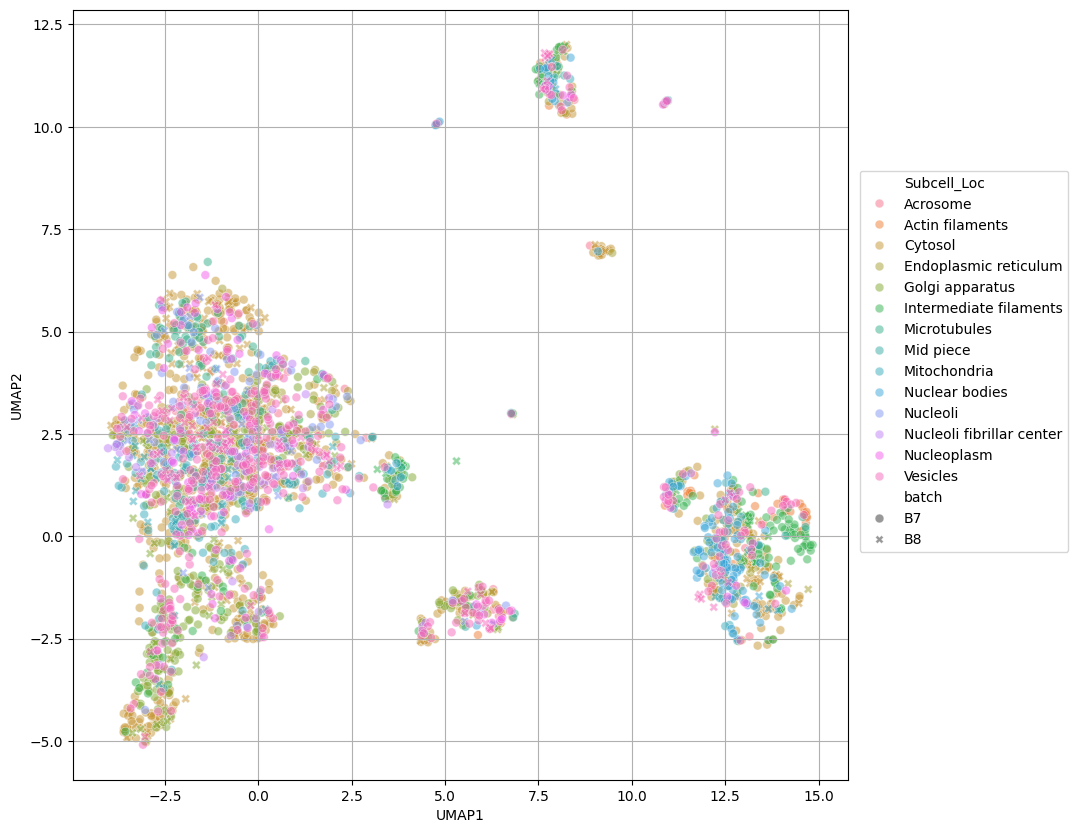

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.grid(True)

# umap_df = umap_df.with_columns(
#     pl.when(pl.col("Allele_type").is_in(list(list_unique_agxt)[:9]))
#     .then(pl.col("Metadata_Protein"))
#     .otherwise(pl.lit("000")).alias(f"{gene}_Variant")
# ).sort(f"{gene}_Variant")
# sns.scatterplot(umap_df_hpa.filter(pl.col("Allele_type") == "Allele"), x="UMAP1", y="UMAP2", color="grey", alpha=.1, ax=ax)

sns.scatterplot(umap_df_hpa.filter(
    (pl.col("Metadata_control_type")=="disease_wt")&(pl.col("Subcell_Loc")!="Multiple")&(pl.col("Additional location").is_null()&(pl.col("Reliability")=="Approved"))
).sort("Subcell_Loc"), x="UMAP1", y="UMAP2", hue="Subcell_Loc", palette="husl", style="batch", ax=ax, s=40, alpha=0.5)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.5, .8, 1.3, 0))
leg._loc = 9

### Visualization by Gene

In [ ]:
def plot_gene_umap(umap_df, gene):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.grid(True)
    umap_df = umap_df.with_columns(
        pl.when(pl.col("Metadata_gene_allele").str.contains(gene))
        .then(pl.col("Metadata_gene_allele"))
        .otherwise(pl.lit("000")).alias(f"{gene}_Variant")
    ).sort(f"{gene}_Variant")
    
    sns.scatterplot(umap_df.filter(pl.col(f"{gene}_Variant") == "000"), x="UMAP1", y="UMAP2", color="grey", alpha=.1, ax=ax, s=50)
    sns.scatterplot(umap_df.filter(pl.col(f"{gene}_Variant") != "000"), x="UMAP1", y="UMAP2", hue=f"{gene}_Variant", style="batch", palette="Set2", ax=ax, s=50, alpha=0.7)

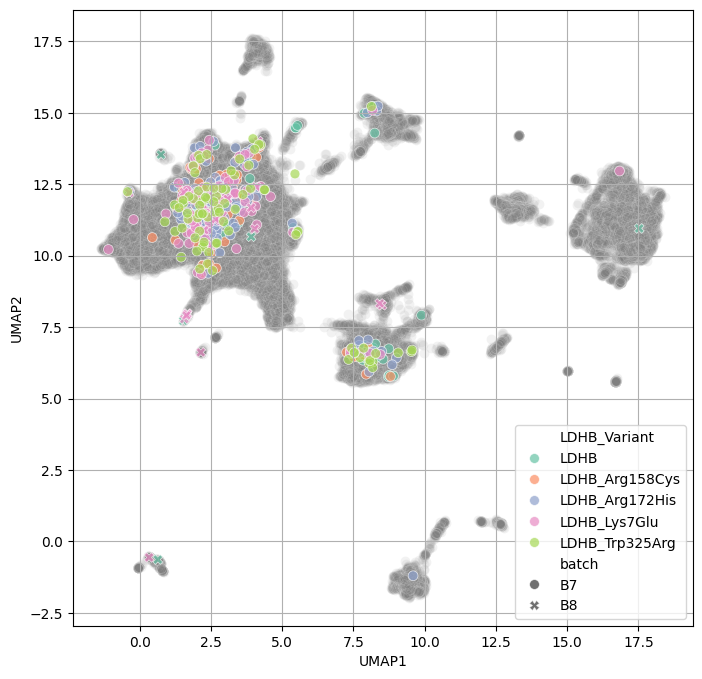

In [101]:
plot_gene_umap(umap_df, "LDHB")

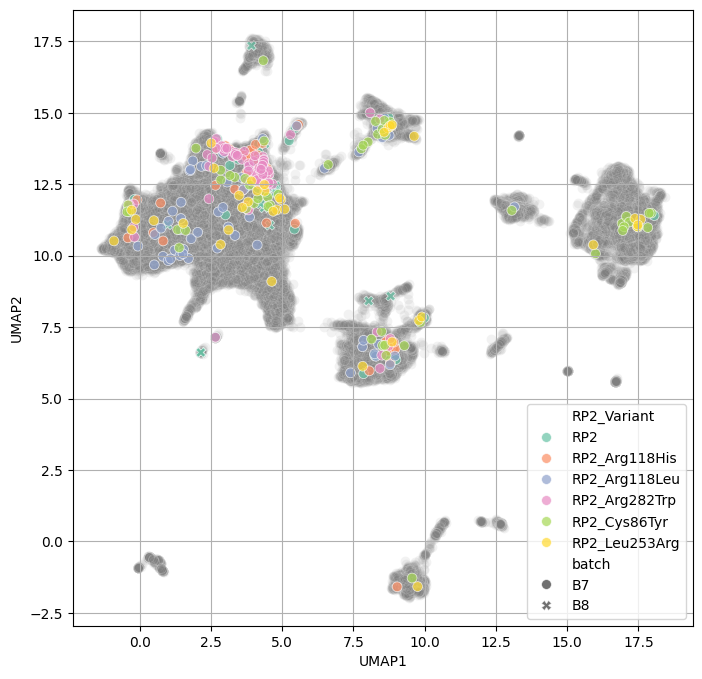

In [102]:
plot_gene_umap(umap_df, "RP2")